# Exploring Electrical Synapses

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to explore electrical synapses between inihibitory subclasses

For an introduction to the Jupyter Notebook interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from aisynphys.database import default_db as db # remove when new DB is available

In [ ]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

Electrical synapses (sometimes referred to as gap junctions) primarily exist between like inhibitory subclasses. Here we will explore the electrical connectivity of innhibitory cells and strength of electrical synapses as measured by junctional conductance.

Let's begin by defining our inhibitory cell subclasses:

In [12]:
inhib_subclasses = {
    'pv': CellClass(cre_type='pvalb', name='pv'),
    'sst': CellClass(cre_type='sst', name='sst'),
    'vip': CellClass(cre_type='vip', name='vip'),
}

We'll now load all of our mouse pairs to measure the rate of electrical connectivity among these subclasses

In [7]:
mouse_pairs = db.pair_query(experiment_type='standard multipatch', species='mouse').all() 
print(len(mouse_pairs))

83006


First we group all of the cells by their subclass, then create all of the possible pair-group combinations, and finally measure the connectivity between them. Note that the `measure_connectiviy` method measures both chemical and electrical connectivity, but that here we use a shorter sigma to fit the distance-adjusted model. See the Connectivity Adjustment notebook as well as our paper [] for more details.

In [13]:
# Group all cells by selected subclasses
cell_groups = classify_cells(inhib_subclasses.values(), pairs=mouse_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(mouse_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups, sigma=75e-6, dist_measure='lateral_distance')

Now we can plot the results as a matrix

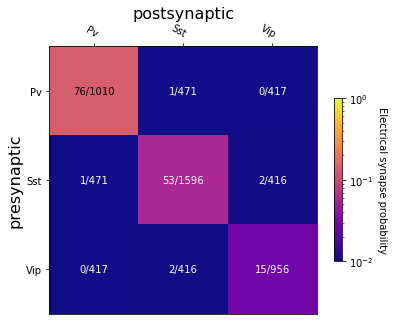

In [14]:
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from aisynphys.ui.notebook import show_connectivity_matrix
%matplotlib inline

# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# define the display labels to use for each cell subclass:
class_labels = {
    'pv': 'Pv',
    'sst':  'Sst',
    'vip': 'Vip',
}

# create a figure/axes to draw on
fig, ax = plt.subplots(figsize=(6, 6))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=results, 
    pre_cell_classes=inhib_subclasses.values(), 
    post_cell_classes=inhib_subclasses.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm,
    distance_adjusted=True,
    ctype='electrical', # here we change the ctype from the default "chemical" to "electrical"
    cbarlabel='Electrical synapse probability',
)

In [15]:
fig.savefig('gap_junction.svg', bbox_inches='tight')

We measure the strength of electrical synapses using junctional conductance. This can be extracted from the gap_junction table along with other parameters such as coupling coefficient and cross-correlation values during the stimulus pulse and during baseline periods.

We can again query the database for mouse pairs but this time filter just for electrical connections between like subclasses

In [25]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
for name, subclass in inhib_subclasses.items():
    pair_query = db.pair_query(
        experiment_type='mouse',
        pre_class=subclass,
        post_class=subclass,
        electrical=True,
    )
    # here we join the GapJunction table so that we can append the junctional_conductance column
    pair_query = pair_query.outerjoin(db.GapJunction, db.GapJunction.pair_id==db.Pair.id)
    pair_query = pair_query.add_column(db.GapJunction.junctional_conductance)

    df = pair_query.dataframe()
    df['pair_class'] = '%s→%s' % (subclass, subclass)
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
pairs['gap_junction.junctional_conductance'] *= 1e9 # we typcially think of conductance on the scale of nano-Siemens (nS)
pairs.head()

,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,pair.distance,pair.lateral_distance,pair.vertical_distance,pair.reciprocal_id,pair.meta,gap_junction.junctional_conductance,pair_class
0,52178,1539,9086,9087,False,False,True,NaN,418,300,0.000092,0.000027,0.000078,52189,None,1.156760,pvalb→pvalb
1,52189,1539,9087,9086,False,False,True,NaN,417,299,0.000092,0.000027,0.000078,52178,None,1.494854,pvalb→pvalb
2,113767,3981,21393,21392,True,False,True,NaN,420,348,0.000084,NaN,NaN,113765,None,0.245593,pvalb→pvalb
3,123654,5109,24793,24795,False,False,True,NaN,507,308,0.000101,NaN,NaN,123661,None,0.665745,pvalb→pvalb
4,123679,5112,24801,24802,False,False,True,NaN,1599,1284,0.000062,NaN,NaN,123682,None,0.776390,pvalb→pvalb


From here we can plot the junctional conductance using the seaborn library

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


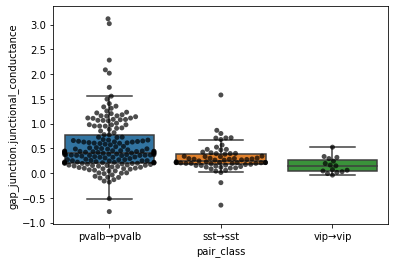

In [28]:
import seaborn as sns

sns.boxplot(data=pairs, x='pair_class', y='gap_junction.junctional_conductance', fliersize=0)
sns.swarmplot(data=pairs, x='pair_class', y='gap_junction.junctional_conductance', color='k', edgecolor='k', alpha=0.7)

Here we can see that electrical connections between Pvalb cells can be stronger than those between Sst or Vip cells